In [ ]:
pip install timm torch torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
import numpy as np
from tqdm import tqdm


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Dataset path
dataset_path = "/content/drive/MyDrive/images"  # Change this to your dataset path

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),               # Resize images to 224x224 for ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))         # Normalization for grayscale images
])

# Load dataset and split into train and validation sets
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class names
class_names = full_dataset.classes
print("Classes:", class_names)


Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Number of classes in the dataset
num_classes = len(class_names)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the input layer to accept grayscale images (1 channel)
model.patch_embed.proj = nn.Conv2d(1, model.patch_embed.proj.out_channels, kernel_size=16, stride=16)

# Modify the output layer to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

# Move model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Training function
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc, precision, recall, f1

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc,precision, recall, f1
# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-5

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc,train_precision, train_recall, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")

    # Validation
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")
    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)


Epoch 1/10


Training: 100%|██████████| 312/312 [57:06<00:00, 10.98s/it]


Training Loss: 0.8125, Accuracy: 69.54%, Precision: 0.65, Recall: 0.70, F1 Score: 0.66


Validation: 100%|██████████| 78/78 [14:40<00:00, 11.29s/it]


Validation Loss: 0.5483, Accuracy: 80.76%, Precision: 0.82, Recall: 0.81, F1 Score: 0.81


Epoch 2/10


Training: 100%|██████████| 312/312 [05:30<00:00,  1.06s/it]


Training Loss: 0.2874, Accuracy: 90.16%, Precision: 0.90, Recall: 0.90, F1 Score: 0.90


Validation: 100%|██████████| 78/78 [00:30<00:00,  2.58it/s]


Validation Loss: 0.0968, Accuracy: 96.79%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


Epoch 3/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0976, Accuracy: 96.77%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


Validation: 100%|██████████| 78/78 [00:30<00:00,  2.57it/s]


Validation Loss: 0.1335, Accuracy: 95.78%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


Epoch 4/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0511, Accuracy: 98.28%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 78/78 [00:29<00:00,  2.60it/s]


Validation Loss: 0.0283, Accuracy: 99.32%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Epoch 5/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.10s/it]


Training Loss: 0.0533, Accuracy: 98.37%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 78/78 [00:29<00:00,  2.61it/s]


Validation Loss: 0.0337, Accuracy: 98.71%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Epoch 6/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0265, Accuracy: 99.19%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation: 100%|██████████| 78/78 [00:29<00:00,  2.61it/s]


Validation Loss: 0.0167, Accuracy: 99.44%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Epoch 7/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0167, Accuracy: 99.56%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:29<00:00,  2.64it/s]


Validation Loss: 0.0145, Accuracy: 99.56%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 8/10


Training: 100%|██████████| 312/312 [05:42<00:00,  1.10s/it]


Training Loss: 0.0236, Accuracy: 99.25%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation: 100%|██████████| 78/78 [00:29<00:00,  2.61it/s]


Validation Loss: 0.0144, Accuracy: 99.60%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 9/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0277, Accuracy: 99.08%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation: 100%|██████████| 78/78 [00:30<00:00,  2.58it/s]


Validation Loss: 0.0765, Accuracy: 98.23%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Epoch 10/10


Training: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]


Training Loss: 0.0297, Accuracy: 99.05%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation: 100%|██████████| 78/78 [00:30<00:00,  2.57it/s]

Validation Loss: 0.0482, Accuracy: 98.43%, Precision: 0.99, Recall: 0.98, F1 Score: 0.98



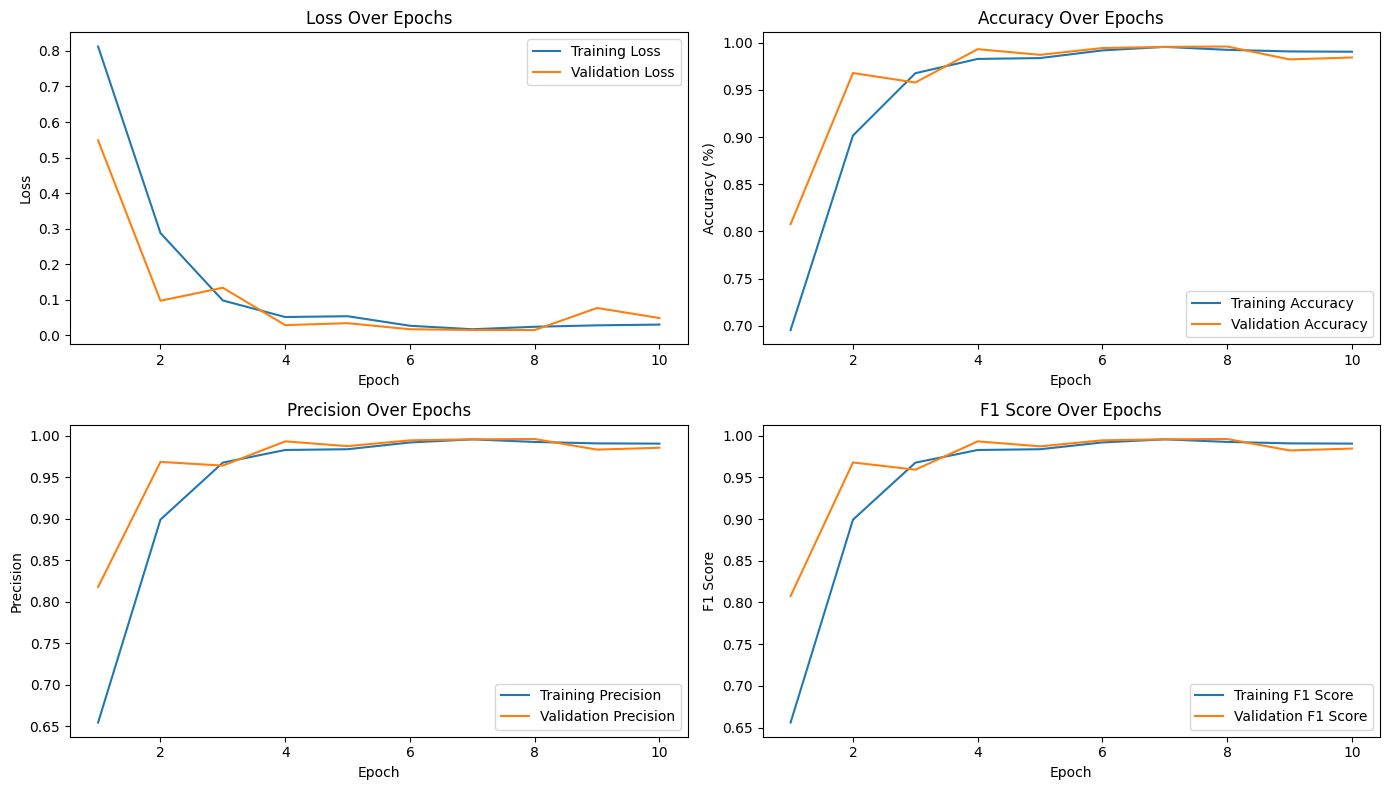

In [ ]:
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()